## Arsitektur Model Seq2Seq

Input Layer (text_input) --> Embedding Layer (text_embedding) --> Encoder (LSTM) --> Attention Mechanism --> Decoder Input Layer (answer_input) --> Embedding Layer (answer_embedding) --> Decoder (LSTM) --> Output Layer (Dense)

             +-----------------------+
             |    text_input         |
             +-----------+-----------+
                         |
                         v
             +-----------------------+
             |   Embedding (text)    |
             +-----------+-----------+
                         |
                         v
             +-----------------------+
             |       Encoder         |
             |        (LSTM)         |
             +-----------+-----------+
                         |
                         v
             +-----------------------+
             |      Attention        |
             +-----------+-----------+
                         |
                         v
             +-----------------------+
             |    answer_input       |
             +-----------+-----------+
                         |
                         v
             +-----------------------+
             |  Embedding (answer)   |
             +-----------+-----------+
                         |
                         v
             +-----------------------+
             |       Decoder         |
             |        (LSTM)         |
             +-----------+-----------+
                         |
                         v
             +-----------------------+
             |        Output         |
             |        (Dense)        |
             +-----------------------+


Penjelasan Diagram:
- Input Layers: Dua input layer, satu untuk teks dan satu untuk jawaban.
- Embedding Layers: Dua embedding layer yang mengubah input teks dan jawaban menjadi vektor embedding.
- Encoder: LSTM layer yang memproses embedding teks.
- Attention Mechanism: Menghitung perhatian antara keluaran encoder dan embedding jawaban.
- Decoder: LSTM layer yang menerima embedding jawaban dan keluaran dari mekanisme perhatian.
- Output Layer: Layer Dense dengan aktivasi softmax untuk menghasilkan distribusi probabilitas token jawaban.

### Cell 1: Mengimpor dan Memverifikasi GPU

In [1]:
import tensorflow as tf

# Verifikasi GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)


Num GPUs Available:  1


### Cell 2: Fungsi untuk Memuat dan Memproses Data

In [2]:
import json
import os

# Fungsi untuk memuat file JSON dari folder
def load_json_files(data_folder):
    data = []
    for filename in os.listdir(data_folder):
        if filename.endswith(".json"):
            file_path = os.path.join(data_folder, filename)
            try:
                with open(file_path, 'r') as file:
                    content = json.load(file)
                    if content:  # Check if file is not empty
                        data.append(content)
            except json.JSONDecodeError:
                print(f"Skipping file {filename} due to JSON decoding error.")
            except Exception as e:
                print(f"Skipping file {filename} due to unexpected error: {e}")
    return data

# Fungsi untuk memproses data menjadi teks dan jawaban
def preprocess_data(data):
    texts = []
    answers = []
    for article in data:
        if 'konten' in article:
            texts.append(article['konten'])
            # Asumsikan bahwa jawaban adalah konten itu sendiri (untuk latihan ini)
            answers.append(article['konten'])
    return texts, answers


### Cell 3: Tokenisasi dan Vektorisasi Data

In [3]:
# Fungsi untuk tokenisasi dan vektorisasi teks dan jawaban
def tokenize_and_vectorize(texts, answers, max_vocab_size=10000, max_seq_length=100):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_vocab_size, oov_token='<UNK>')
    tokenizer.fit_on_texts(texts + answers)
    
    text_sequences = tokenizer.texts_to_sequences(texts)
    answer_sequences = tokenizer.texts_to_sequences(answers)
    
    padded_texts = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_seq_length, padding='post')
    padded_answers = tf.keras.preprocessing.sequence.pad_sequences(answer_sequences, maxlen=max_seq_length, padding='post')
    
    return padded_texts, padded_answers, tokenizer


### Cell 4: Membuat Pipeline Data

In [4]:
# Fungsi untuk membuat pipeline data
def create_data_pipeline(padded_texts, padded_answers, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices(((padded_texts, padded_answers), padded_answers))
    dataset = dataset.shuffle(buffer_size=len(padded_texts))
    dataset = dataset.batch(batch_size)
    return dataset


### Cell 5: Membuat Model

In [5]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Attention, Concatenate
from tensorflow.keras.models import Model

# Fungsi untuk membuat model Seq2Seq
def create_seq2seq_model(vocab_size, embedding_dim, units):
    # Input layers
    text_input = Input(shape=(None,), name='text_input')
    answer_input = Input(shape=(None,), name='answer_input')
    
    # Embedding layers
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)
    text_embedding = embedding(text_input)
    answer_embedding = embedding(answer_input)
    
    # Encoder
    encoder_lstm = LSTM(units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_output, state_h, state_c = encoder_lstm(text_embedding)
    
    # Mengubah dimensi answer_embedding agar sesuai dengan encoder_output
    answer_dense = Dense(units)(answer_embedding)
    
    # Attention mechanism
    attention = Attention()([answer_dense, encoder_output])
    
    # Decoder
    decoder_lstm = LSTM(units, return_sequences=True, return_state=True, name='decoder_lstm')
    decoder_output, _, _ = decoder_lstm(attention, initial_state=[state_h, state_c])
    
    # Output layer
    output = Dense(vocab_size, activation='softmax', name='output')(decoder_output)
    
    # Build the model
    model = Model(inputs=[text_input, answer_input], outputs=output)
    
    return model


### Cell 6: Melatih Model

In [6]:
# Load and preprocess data
folder_path = '../Dataset/generative_dataset'
data = load_json_files(folder_path)
texts, answers = preprocess_data(data)
padded_texts, padded_answers, tokenizer = tokenize_and_vectorize(texts, answers)

Skipping file 0312.json due to JSON decoding error.
Skipping file 0540.json due to JSON decoding error.
Skipping file 0541.json due to JSON decoding error.
Skipping file 0542.json due to JSON decoding error.
Skipping file 0543.json due to JSON decoding error.
Skipping file 0544.json due to JSON decoding error.
Skipping file 0545.json due to JSON decoding error.
Skipping file 0546.json due to JSON decoding error.
Skipping file 0547.json due to JSON decoding error.
Skipping file 0548.json due to JSON decoding error.
Skipping file 0549.json due to JSON decoding error.
Skipping file 0550.json due to JSON decoding error.
Skipping file 0551.json due to JSON decoding error.
Skipping file 0552.json due to JSON decoding error.
Skipping file 0553.json due to JSON decoding error.
Skipping file 0554.json due to JSON decoding error.
Skipping file 0555.json due to JSON decoding error.
Skipping file 0556.json due to JSON decoding error.
Skipping file 0557.json due to JSON decoding error.
Skipping fil

In [7]:
# Create data pipeline
batch_size = 32
data_pipeline = create_data_pipeline(padded_texts, padded_answers, batch_size)

# Create the model
vocab_size = 10000
embedding_dim = 256
units = 512

model = create_seq2seq_model(vocab_size, embedding_dim, units)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Melatih model
epochs = 350  # Atur jumlah epoch sesuai kebutuhan
history = model.fit(data_pipeline, epochs=epochs)

# Menyimpan model setelah pelatihan
model.save('../saved_model/saved_notebook_03/seq2seq_model.h5')

# Menyimpan tokenizer
import pickle

with open('../saved_model/saved_notebook_03/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)


Epoch 1/350
7/7 [==============================] - 11s 71ms/step - loss: 2.5198 - accuracy: 0.0543
Epoch 2/350
7/7 [==============================] - 1s 72ms/step - loss: 1.7505 - accuracy: 0.0935
Epoch 3/350
7/7 [==============================] - 0s 71ms/step - loss: 1.3285 - accuracy: 0.1161
Epoch 4/350
7/7 [==============================] - 1s 71ms/step - loss: 1.2768 - accuracy: 0.1307
Epoch 5/350
7/7 [==============================] - 0s 69ms/step - loss: 1.2507 - accuracy: 0.1280
Epoch 6/350
7/7 [==============================] - 1s 70ms/step - loss: 1.2297 - accuracy: 0.1523
Epoch 7/350
7/7 [==============================] - 1s 73ms/step - loss: 1.2160 - accuracy: 0.1652
Epoch 8/350
7/7 [==============================] - 0s 70ms/step - loss: 1.2040 - accuracy: 0.1701
Epoch 9/350
7/7 [==============================] - 0s 69ms/step - loss: 1.1949 - accuracy: 0.1900
Epoch 10/350
7/7 [==============================] - 0s 70ms/step - loss: 1.1885 - accuracy: 0.1848
Epoch 11/350
7/7 [

### Cell 7: Visualisasi Model dan Hasil Pelatihan

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


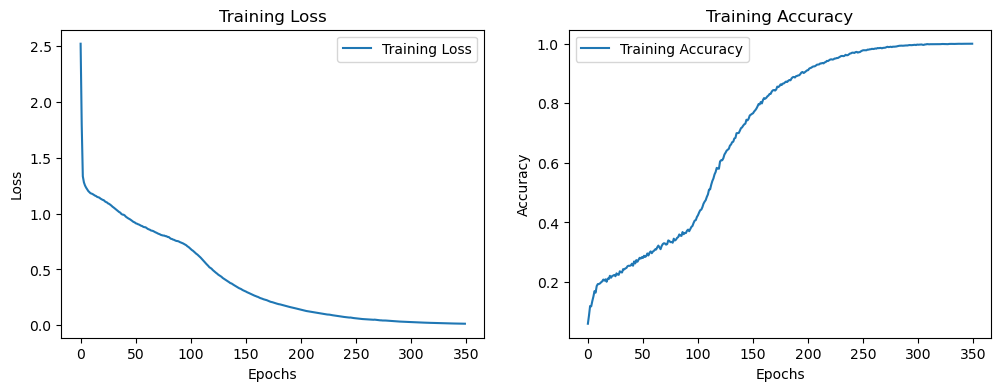

In [8]:
import matplotlib.pyplot as plt

# Plotting model architecture
tf.keras.utils.plot_model(model, to_file='seq2seq_model_architecture.png', show_shapes=True, show_layer_names=True)

# Visualisasi loss dan akurasi
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

# Menampilkan hasil pelatihan
plot_training_history(history)


In [9]:
# Menampilkan arsitektur model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 answer_input (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 text_input (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    2560000     ['text_input[0][0]',             
                                                                  'answer_input[0][0]']           
                                                                                                  
 dense (Dense)                  (None, None, 512)    131584      ['embedding[1][0]']          

### Cell 8: Memuat Model dan Tokenizer, dan Fungsi untuk Menghasilkan Output


In [11]:
# Memuat model yang telah disimpan
model = tf.keras.models.load_model('./saved_model/saved_notebook_03/seq2seq_model.h5')

# Memuat tokenizer
with open('./saved_model/saved_notebook_03/tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

# Fungsi untuk menghasilkan teks dari input teks
def generate_text(input_text):
    input_seq = tokenizer.texts_to_sequences([input_text])
    padded_input = tf.keras.preprocessing.sequence.pad_sequences(input_seq, maxlen=100, padding='post')

    # Inisialisasi jawaban dengan urutan kosong
    decoded_sentence = []

    for _ in range(100):
        padded_answer = tf.keras.preprocessing.sequence.pad_sequences([decoded_sentence], maxlen=100, padding='post')

        # Menggunakan model untuk memprediksi output
        predicted_seq = model.predict([padded_input, padded_answer])

        # Mendapatkan token yang diprediksi
        predicted_token = predicted_seq.argmax(axis=-1)[0, len(decoded_sentence)]
        decoded_sentence.append(predicted_token)

    # Mengkonversi token menjadi teks
    generated_text = tokenizer.sequences_to_texts([decoded_sentence])[0]
    return generated_text

# Fungsi untuk menerima input dan menghasilkan output
def interactive_text_generation():
    while True:
        user_input = input("Masukkan pertanyaan atau 'exit' untuk keluar: ")
        if user_input.lower() == 'exit':
            break
        generated_text = generate_text(user_input)
        print(f"Teks yang dihasilkan:\n{generated_text}")

# Memulai interaksi
interactive_text_generation()

Teks yang dihasilkan:
decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators decorators

## Rangkuman Model Seq2Seq untuk Generative AI

#### Arsitektur Model

Model Seq2Seq (Sequence-to-Sequence) yang digunakan terdiri dari:
- Input Layer: Dua input layer, satu untuk teks pertanyaan (text_input) dan satu untuk jawaban (answer_input).
- Embedding Layer: Dua embedding layer yang mengubah input teks dan jawaban menjadi representasi vektor embedding.
- Encoder: LSTM encoder yang memproses embedding teks dan menghasilkan keluaran dan status tersembunyi.
- Dense Layer: Mengubah dimensi embedding jawaban agar sesuai dengan keluaran encoder.
- Attention Mechanism: Menghitung skor perhatian antara embedding jawaban dan keluaran encoder.
- Decoder: LSTM decoder yang menerima embedding jawaban dan keluaran dari mekanisme perhatian, kemudian menghasilkan urutan keluaran berdasarkan konteks dari encoder dan perhatian.
- Output Layer: Layer Dense dengan aktivasi softmax yang menghasilkan distribusi probabilitas atas token dalam vokabulari jawaban.

#### Parameter Model
- vocab_size: 10,000
- embedding_dim: 256 (dapat ditingkatkan)
- units: 512 (dapat ditingkatkan)

#### Proses Pelatihan
- Data Preprocessing: Memuat dan memproses data JSON untuk teks dan jawaban.
- Tokenization and Vectorization: Tokenisasi dan padding teks dan jawaban.
- Creating Data Pipeline: Membuat pipeline data menggunakan tf.data.Dataset.
- Model Training: Melatih model dengan data yang telah diproses dan pipeline data.
- Saving Model and Tokenizer: Menyimpan model dan tokenizer setelah pelatihan.
- Visualization: Memvisualisasikan arsitektur model dan hasil pelatihan (loss dan akurasi).

#### Penyesuaian yang Dilakukan
- Meningkatkan jumlah epochs.
- Menambahkan callback EarlyStopping.
- Menghapus penggunaan token '<start>' dan '<end>'.
- Meningkatkan parameter model seperti embedding_dim dan units.

#### Saran untuk Peningkatan di Masa Depan
Dataset yang Lebih Besar dan Berkualitas:

- Mengumpulkan lebih banyak data berkualitas untuk meningkatkan kemampuan model dalam menghasilkan jawaban yang bermakna.
- Menambah variasi dalam dataset untuk mencakup berbagai jenis pertanyaan dan jawaban.

Penyesuaian Parameter Model:

- Meningkatkan embedding_dim dan units untuk memberikan model lebih banyak kapasitas belajar.
- Bereksperimen dengan berbagai arsitektur model, seperti Transformer atau GRU.

Tuning Hyperparameter:
- Melakukan tuning hyperparameter menggunakan teknik seperti Grid Search atau Random Search untuk menemukan kombinasi parameter yang optimal.
- Menambahkan dropout layer untuk mengurangi overfitting.

Meningkatkan Jumlah Epochs:
- Meningkatkan jumlah epochs dan menggunakan callback EarlyStopping untuk menghentikan pelatihan ketika model berhenti membaik.

Peningkatan Preprocessing:

- Memperbaiki preprocessing data dengan teknik pembersihan data yang lebih baik.
- Menambahkan teknik augmentasi data untuk meningkatkan variasi dalam dataset.

Evaluasi Model:

- Menggunakan metrik evaluasi tambahan seperti BLEU atau ROUGE untuk mengevaluasi kinerja model dalam menghasilkan teks.
- Menggunakan dataset validasi yang lebih besar dan representatif untuk evaluasi yang lebih akurat.